In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [4]:
data = pd.read_csv('./data/processed_train.csv')
train_df,test_df = train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])

train_X = train_df[train_df.columns[1:]]
train_y = train_df[train_df.columns[:1]]

test_X = test_df[test_df.columns[1:]]
test_y = test_df[test_df.columns[:1]]

X = data[data.columns[1:]]
y = data['Survived']

## 投票分类器

In [7]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('linear_svm',svm.SVC(kernel='linear',probability=True)),
    ('rbf_svm',svm.SVC(kernel='rbf',C=0.5,gamma=0.1,probability=True)),
    ('lr',LogisticRegression(C=0.05)),
    ('knn',KNeighborsClassifier(n_neighbors=10)),
    ('rf',RandomForestClassifier(n_estimators=500,random_state=0)),
    ('dt',DecisionTreeClassifier(random_state=0)),
    ('nb',GaussianNB())
]
vc = VotingClassifier(estimators=estimators,voting='soft')
vc.fit(train_X,train_y)
print('The accuracy for ensembled model is:',vc.score(test_X,test_y))


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy for ensembled model is: 0.8208955223880597


In [10]:
cross = cross_val_score(vc,X,y,cv=10,scoring='accuracy')
cross.mean()

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.8237660310974917

## Bagging 集成

In [11]:
from sklearn.ensemble import BaggingClassifier

# bagged knn
model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_y)
prediction = model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_y))

result=cross_val_score(model,X,y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy for bagged KNN is: 0.835820895522388
The cross validated score for bagged KNN is: 0.8148893428668709


In [12]:
# bagged dt
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_y)
prediction = model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_y))
result=cross_val_score(model,X,y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy for bagged Decision Tree is: 0.8246268656716418
The cross validated score for bagged Decision Tree is: 0.8204826353421859


## Boosting 集成
### AdaBoost

In [13]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result = cross_val_score(ada,X,y,cv=10,scoring='accuracy')
result.mean()

0.8249526160481218

In [17]:
# 进行网格搜索
n_estimators = list(range(100,1100,100))
learning_rate = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper = {'n_estimators':n_estimators,'learning_rate':learning_rate}
gd = GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,y)
print(gd.best_score_)
print(gd.best_estimator_)

0.8316498316498316
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.05, n_estimators=200, random_state=None)


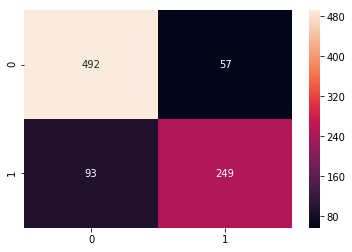

In [18]:
# ada的最佳模型的混淆矩阵
ada = AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result = cross_val_predict(ada,X,y,cv=10)
sns.heatmap(confusion_matrix(y,result),annot=True,fmt='2.0f')


### GDBT

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result = cross_val_score(grad,X,y,cv=10,scoring='accuracy')
result.mean()

0.8182862331176939

### Xgboost

Text(0.5, 1.0, 'Feature Importance in Random Forest')

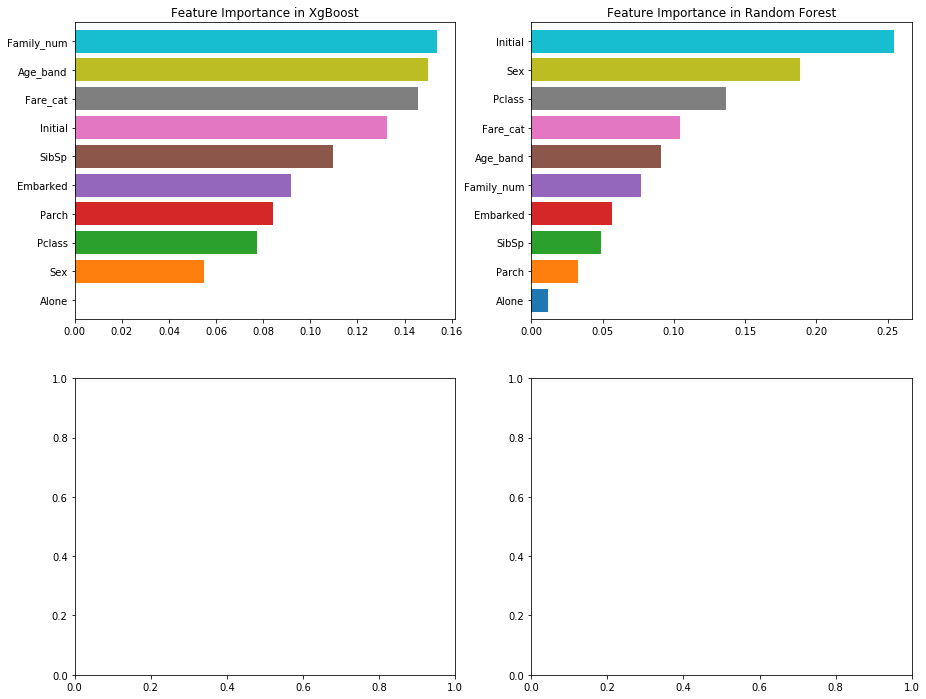

In [23]:
import xgboost as xgb

fig,ax = plt.subplots(2,2,figsize=(15,12))
model = xgb.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in XgBoost')

model = RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1])
ax[0,1].set_title('Feature Importance in Random Forest')

model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0])
ax[1,0].set_title('Feature Importance in Random Forest')

model = RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1])
ax[0,1].set_title('Feature Importance in Random Forest')
